# EDA on SRA Run Table

In [1]:
import pandas as pd

In [2]:
sra = pd.read_csv("/teams/DSC180A_FA20_A00/b04genetics/group_4/opioids-od-genome-analysis/data/external/SRA_case_table.csv")
sra = sra.drop('Case', axis=1)
sra.tail()

,SRR Number,Cause of Death,Age,Race,Sex,Brain pH,RIN,Opioids,Cocaine,Group
45,SRR7949805,Drug abuse,57,B,M,6.47,7.23,Mo,1,Experimental
46,SRR7949802,Drug abuse,59,W,M,6.43,6.70,"Co, Mo",0,Experimental
47,SRR7949803,Drug abuse,59,B,M,6.35,6.90,"Co, Mo",0,Experimental
48,SRR7949812,Drug abuse,60,B,M,6.64,6.90,"Co, Mo",1,Experimental
49,SRR7949813,Drug abuse,61,B,M,6.26,7.00,"Fe, Mo",1,Experimental


## See differences of quantitative values between two groups

In [3]:
group_means = sra.groupby('Group').mean()
group_means

,Age,Brain pH,RIN,Cocaine
Group,,,,
Control,50.400000,6.6015,7.3875,0.0
Experimental,51.466667,6.5330,7.2490,0.6


In [4]:
diff_group_means = group_means.diff()
diff_group_means

,Age,Brain pH,RIN,Cocaine
Group,,,,
Control,NaN,NaN,NaN,NaN
Experimental,1.066667,-0.0685,-0.1385,0.6


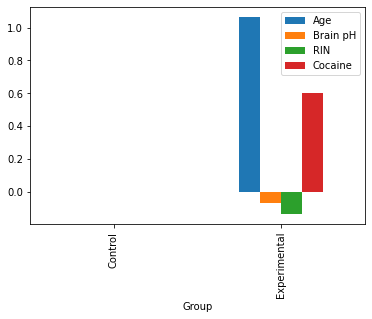

In [27]:
diff_group_means.plot(kind='bar')

## Analyze difference in experimental group of those who used cocaine and those who didn't 

In [5]:
exper = sra[sra.Group == 'Experimental']
cocaine_use_means = exper.groupby('Cocaine').mean()
cocaine_use_means

,Age,Brain pH,RIN
Cocaine,,,
0,51.750000,6.494167,7.2175
1,51.277778,6.558889,7.2700


In [25]:
cocaine_use_diff = cocaine_use_means.diff()
cocaine_use_diff

,Age,Brain pH,RIN
Cocaine,,,
0,NaN,NaN,NaN
1,-0.472222,0.064722,0.0525


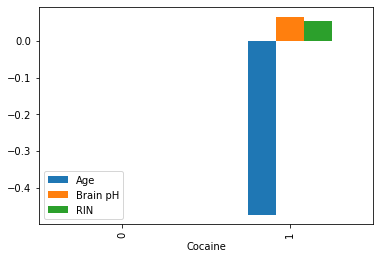

In [26]:
cocaine_use_diff.plot(kind='bar')

## One-Hot-Encode Opioids Column

In [7]:
sra.Opioids.unique()

array(['Neg', 'Fe', 'Mo', 'Fe, He', 'Co, He, Mo', 'Fe, Hy', 'Me',
       'Co, Fe, He, Mo', 'He, Mo', 'Ox', 'Hy', 'Co, Mo', 'Fe, Mo'],
      dtype=object)

In [8]:
opioids_split = sra['Opioids'].str.split(',')
opioids_split = opioids_split.apply(lambda x: [y.strip() for y in x])
sra['Opioids'] = opioids_split
sra['Opioids'] = sra.Opioids.apply(lambda x: [] if x == ['Neg'] else x)

In [9]:
sra.head(3)

,SRR Number,Cause of Death,Age,Race,Sex,Brain pH,RIN,Opioids,Cocaine,Group
0,SRR7949817,"MGSW, aortic dissection",41,B,M,6.64,8.04,[],0,Control
1,SRR7949816,HTCVD,42,B,M,6.78,7.03,[],0,Control
2,SRR7949815,ASCVD,46,B,M,6.71,7.20,[],0,Control


In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
sra_ohe = sra.join(pd.DataFrame(mlb.fit_transform(sra.pop('Opioids')),
                          columns=mlb.classes_,
                          index=sra.index))

In [11]:
sra_ohe = sra_ohe.set_index('SRR Number')
sra_ohe.tail()

,Cause of Death,Age,Race,Sex,Brain pH,RIN,Cocaine,Group,Co,Fe,He,Hy,Me,Mo,Ox
SRR Number,,,,,,,,,,,,,,,
SRR7949805,Drug abuse,57,B,M,6.47,7.23,1,Experimental,0,0,0,0,0,1,0
SRR7949802,Drug abuse,59,W,M,6.43,6.70,0,Experimental,1,0,0,0,0,1,0
SRR7949803,Drug abuse,59,B,M,6.35,6.90,0,Experimental,1,0,0,0,0,1,0
SRR7949812,Drug abuse,60,B,M,6.64,6.90,1,Experimental,1,0,0,0,0,1,0
SRR7949813,Drug abuse,61,B,M,6.26,7.00,1,Experimental,0,1,0,0,0,1,0


## Pie Chart of Drug Popularity

([<matplotlib.patches.Wedge at 0x7f6b43f6ed50>,
 [Text(1.5945441662377633, 1.5157271858474788, 'Co'),
  Text(-0.658598753255849, 2.099106400878679, 'Fe'),
  Text(-2.1549658319672864, 0.44285693294058387, 'He'),
  Text(-1.7397067737801388, -1.3466329645688546, 'Hy'),
  Text(-1.4330196611302148, -1.6692676989668989, 'Me'),
  Text(0.8675826675394218, -2.021707277274626, 'Mo'),
  Text(2.1971763055119173, -0.11142837384168598, 'Ox')],
 [Text(1.159668484536555, 1.1023470442527117, '24%'),
  Text(-0.4789809114587993, 1.5266228370026758, '11%'),
  Text(-1.5672478777943901, 0.3220777694113337, '23%'),
  Text(-1.265241290021919, -0.9793694287773488, '5%'),
  Text(-1.042196117185611, -1.2140128719759264, '2%'),
  Text(0.6309692127559431, -1.4703325652906372, '34%'),
  Text(1.597946404008667, -0.08103881733940799, '2%')])

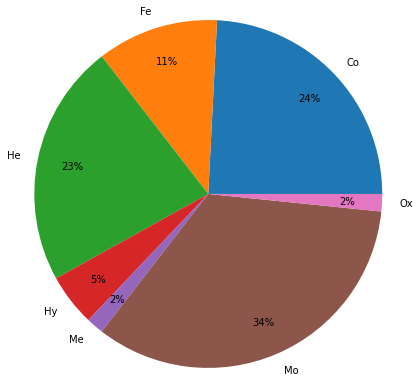

In [51]:
from matplotlib.pyplot import pie, axis, show
drugs = sra_ohe[['Co', 'Fe', 'He', 'Hy', 'Me', 'Mo', 'Ox']]
pie(drugs.sum(), labels = drugs.columns, autopct='%1.0f%%', labeldistance=1.1, pctdistance=.8, radius=2)

## Distribution of Race

([<matplotlib.patches.Wedge at 0x7f69eb045350>,
 [Text(-1.4023329298081773, 1.6951290080626946, 'B'),
  Text(1.4023330885176026, -1.6951288767668027, 'W')],
 [Text(-1.0198784944059471, 1.2328210967728688, '72%'),
  Text(1.0198786098309838, -1.2328210012849474, '28%')])

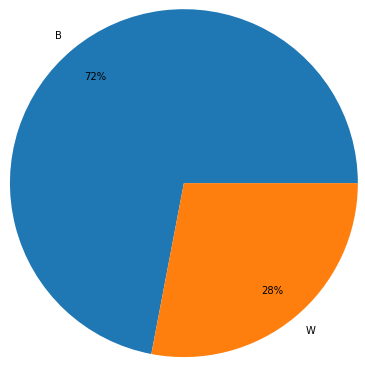

In [66]:
race = sra.Race.value_counts()
pie(race, labels = race.index, autopct='%1.0f%%', labeldistance=1.1, pctdistance=.8, radius=2)

## Distribution of Age

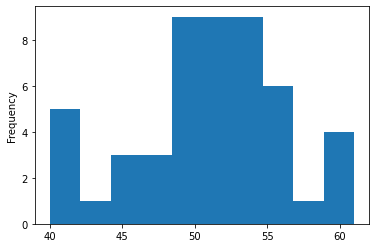

In [67]:
sra.Age.plot(kind='hist')

## Scatterplot matrix to see relationships between features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f69ed421190>,
      dtype=object)

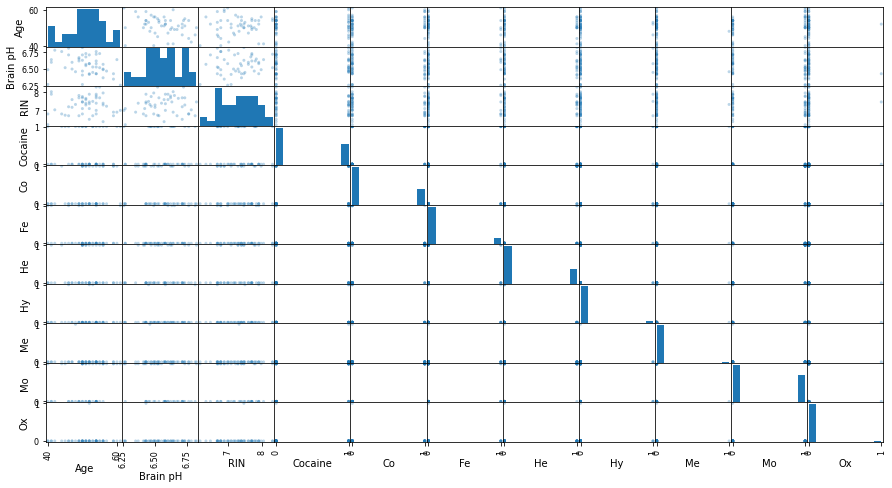

In [63]:
pd.plotting.scatter_matrix(sra_ohe, alpha=0.3, figsize=(15,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f69f3079e90>,
      dtype=object)

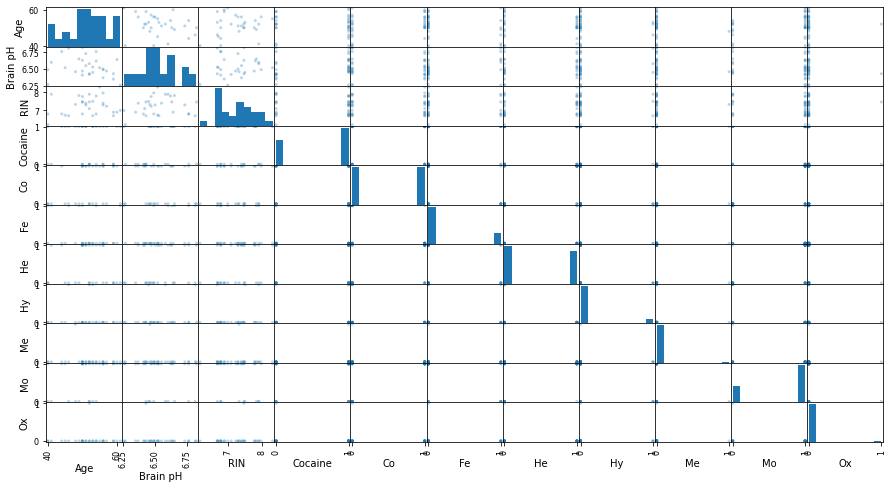

In [62]:
pd.plotting.scatter_matrix(sra_ohe[sra_ohe.Group=='Experimental'], alpha=0.3, figsize=(15,8))